# Dataset Introduction:

The University of California at Irvine hosts a wine quality dataset for the red variant of the Portuguese "Vinho Verde" wine.  Here, my goal is to create a model that can predict a wine's quality based on its physiochemical properties and to analyze the most important variables in determing a wine's quality. 

In practice, knowing which properties to focus on can help winemaker avoid making 'Poor' wines and aid in making 'Good' to 'Great' wines as cost-efficiently as possible.  Wine sellers as well could use this model to market and sell the best wines.     

# Modelling small, unbalanced data with few features:

Throughout this analysis, I encountered problems with small, unbalanced data.  I hope to explain how one may approach this problem when encountered.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

In [3]:
wine = pd.read_csv(r'C:\Users\chase\Anaconda3\Database_Dictionary\Kaggle\red-wine-quality\winequality-red.csv') 

#### Exploring the Data

First, let's look at how our outcome variable 'quality' is balanced.

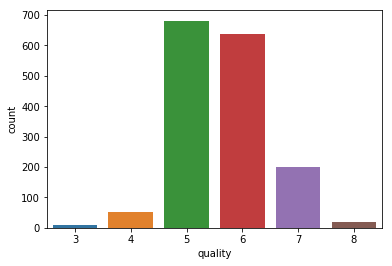

In [10]:
sns.countplot(wine.quality)

Immediately we can see that our outcome variable 'quality' is unbalanced, with the vast majority of wine qualities falling in the middle 5 to 6 quality range.  Also, the qualities only range from 3 to 8.  Because of the low number of samples with 3, 4, 7, and 8 quality designations I'll group some of the qualities together.

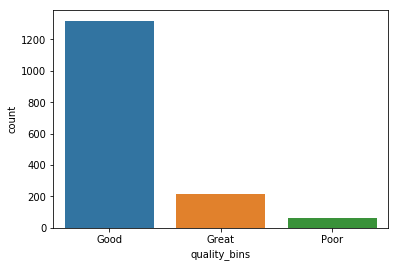

In [12]:
## Creating quality bins to use as a categorical variable
wine['quality_bins'] = ['Poor' if x <5 else 'Great' if x > 6 else 'Good' for x in wine['quality']]
sns.countplot(wine.quality_bins)

In [13]:
wine.quality_bins.value_counts()

Good     1319
Great     217
Poor       63
Name: quality_bins, dtype: int64

I grouped the 'quality' features into 'Poor', 'Good', and 'Great' designations in a 'quality_bins' feature to try to increase the number of 'Poor' and 'Great' wines for modeling.  Unfortunately there are still only 63 wines with the 'Poor' designation,   therefore we need to subsample the Good and Great wines to avoid creating a model with sampling bias.  

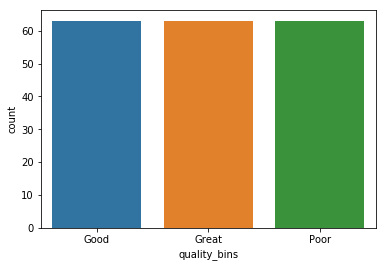

In [24]:
goodwine = wine[wine['quality_bins']=='Good'].sample(n=63, random_state=9192)
greatwine = wine[wine['quality_bins']=='Great'].sample(n=63, random_state=9193)
poorwine = wine[wine['quality_bins']=='Poor']
new1_wine = pd.concat([goodwine, greatwine, poorwine])

sns.countplot(new1_wine['quality_bins'])

C:\Users\chase\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


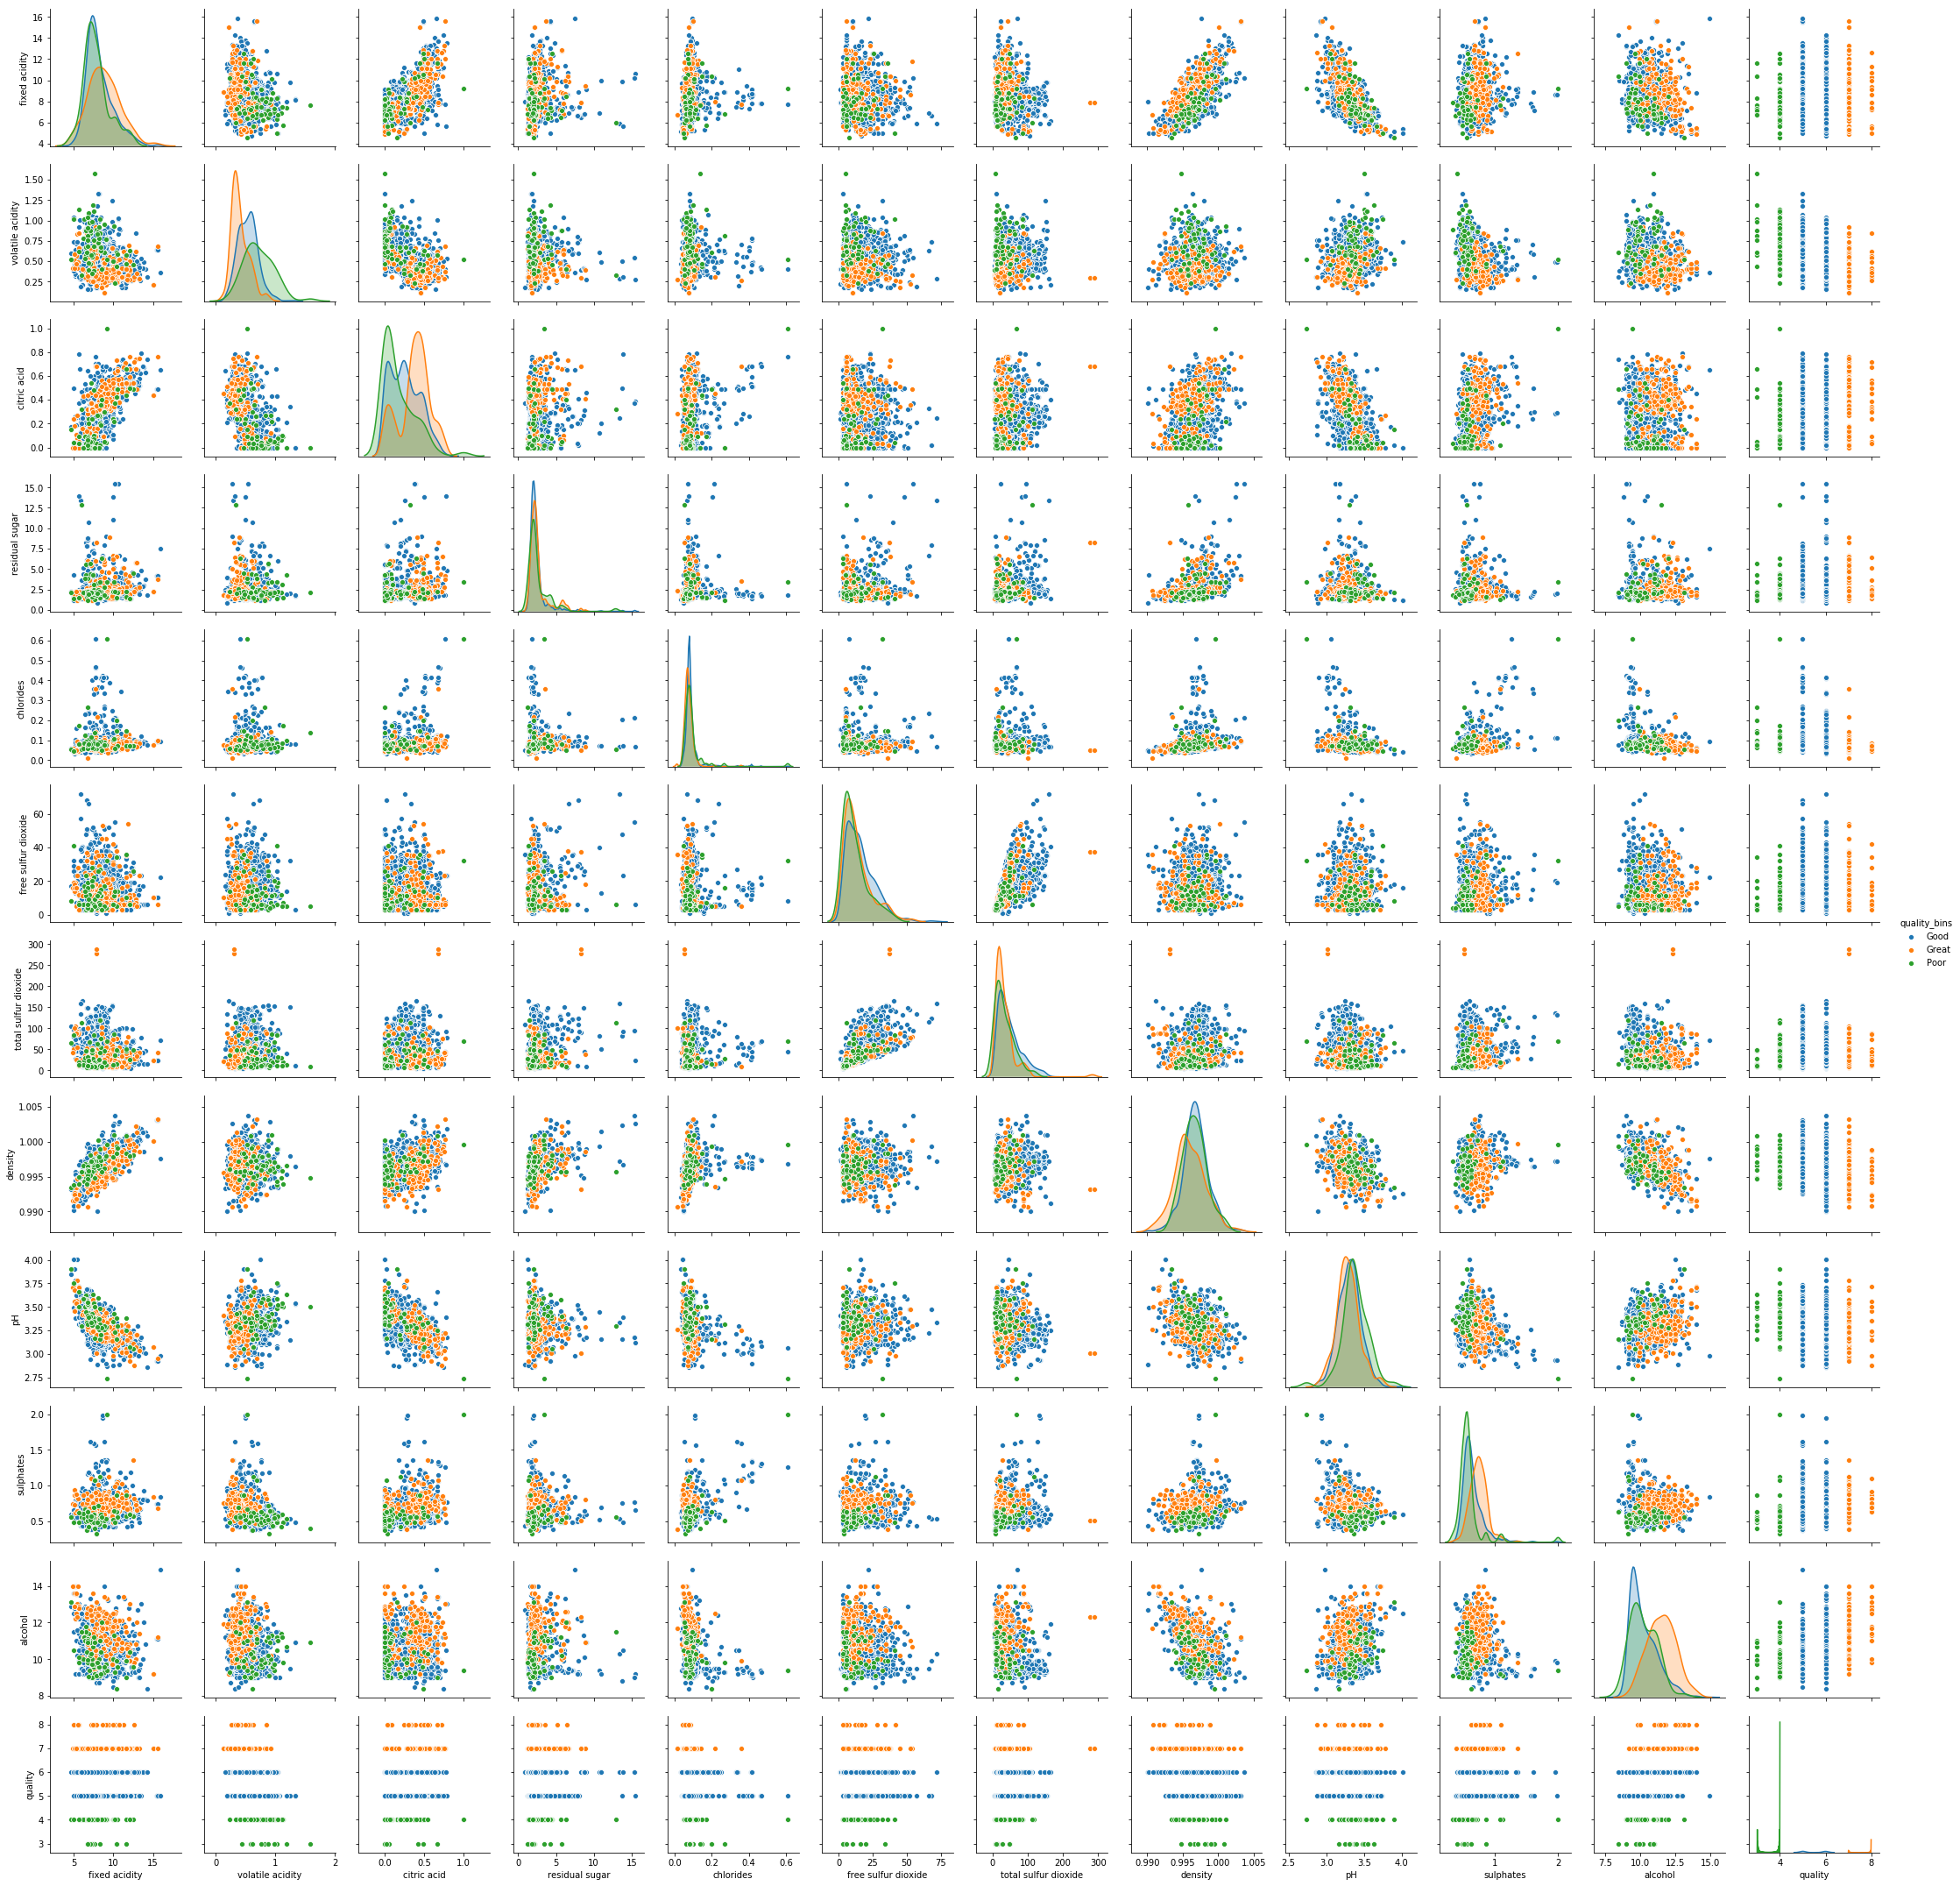

In [375]:
g = sns.pairplot(wine, hue="quality_bins")

plt.show()

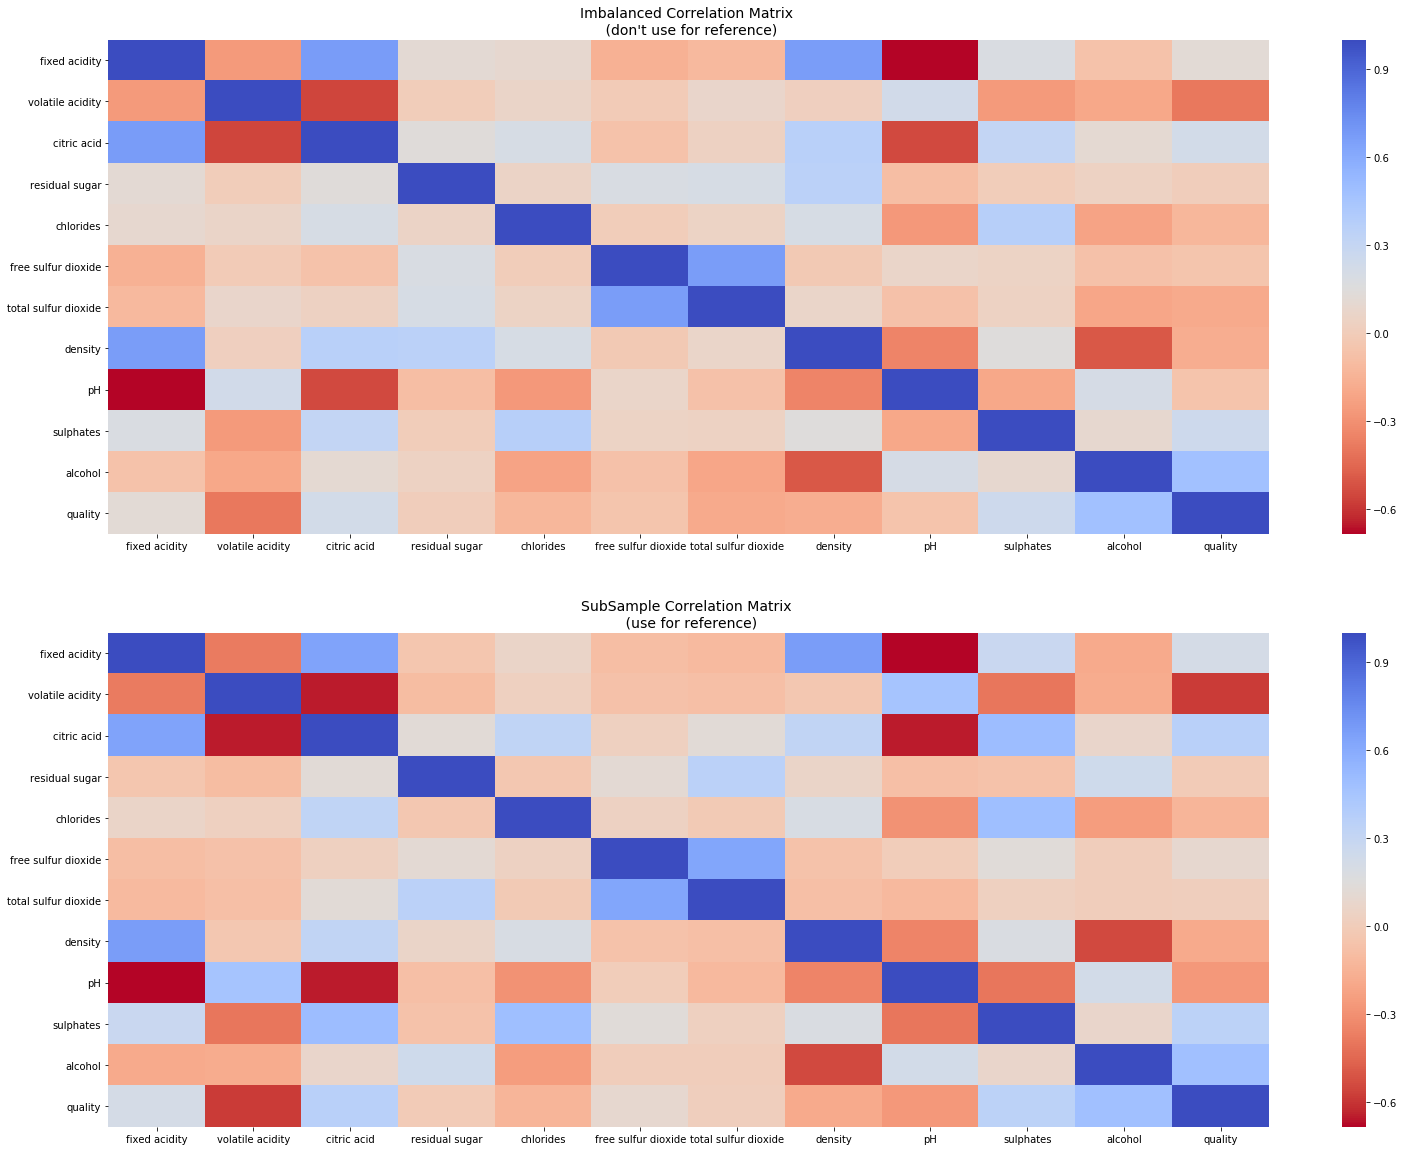

In [34]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(26,20))

# Entire DataFrame
corr = wine.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':30}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new1_wine.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':30}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Our smaller, balanced dataset follows the original dataset correlations which is comforting.  From the correlation matrices we can see that volatile acidity, pH, and density appear negatively correlated with quality, and citric acid, alcohol, and sulphates appear positively correlated with quality.  However, the correlations are very weak.

Next, I'll try a Random Forest Classsifier on the training data to see if we can make a model that can be applied to the entire dataset.

In [207]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

Ytrain = new1_wine['quality_bins']
Xtrain = new1_wine.drop(columns=['quality_bins', 'quality'])

rfc.fit(Xtrain, Ytrain)

print('Model score (test dataset):',rfc.score(Xtrain, Ytrain), '\n')

from sklearn.model_selection import cross_val_score

print('Five fold cross validation scores (test dataset):', cross_val_score(rfc, Xtrain, Ytrain, cv=5), '\n')

Ytest = wine['quality_bins']
Xtest = wine.drop(columns=['quality_bins', 'quality'])

predicted = rfc.predict(Xtest)

print('Model score (entire dataset):\n', rfc.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confusion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted))



Model score (test dataset): 0.9841269841269841 

Five fold cross validation scores (test dataset): [0.58974359 0.56410256 0.69230769 0.61111111 0.58333333] 

Model score (entire dataset):
 0.683552220137586 

Confustion Matrix (entire dataset): 
 [[858 228 233]
 [ 39 174   4]
 [  2   0  61]]


Here we can see that the model is overfitting and performing poorly both in cross validation of the test dataset and when applied to the entire dataset.  However, above we can see that the true values of 'Good', 'Great', and 'Poor' wines in the original dataset are 1319, 217, and 63, respectively, so our model is actually good at predicting true 'Poor' wines.  But, the model is poor at correctly predicting 'Good' and 'Great' wines.  

So what might be the problem here?  We haven't trimmed down any of the features so let's try using the Random Forest Classifier built in 'feature_importances_' function to trim our features down to the five most important features that we can use to model.

In [199]:
feat = rfc.feature_importances_

feat_impo = feat

values = list(feat_impo)

key = list(Xtrain.columns)

impo_feat = dict(zip(key, values))

feature_scores = pd.DataFrame.from_dict(impo_feat, orient='index')

feature_scores = feature_scores.sort_values(by=0, ascending=False)

print('Variance explained in training dataset by features: \n',feature_scores,'\n')

print('Variance explained by top 5 features: \n', feature_scores[:5].sum())

Variance explained in training dataset by features: 
                              0
volatile acidity      0.185428
sulphates             0.133855
alcohol               0.123828
total sulfur dioxide  0.080685
citric acid           0.076814
density               0.074067
chlorides             0.068049
residual sugar        0.067604
pH                    0.065432
fixed acidity         0.062829
free sulfur dioxide   0.061408 

Variance explained by top 5 features: 
 0    0.600611
dtype: float64


Our top five features here explain 60% of the variance, with features from our 4th-most important onward only decreasing marginally onward in the amount they expalin variance.  Let's try a model with the top five features and see if it helps:

In [210]:
rfc2 = RandomForestClassifier()

Xtrain2 = new1_wine[list(feature_scores.iloc[:5].index)]
Xtest2 = wine[list(feature_scores.iloc[:5].index)]
Ytest = wine['quality_bins']

rfc2.fit(Xtrain2, Ytrain)

print('Model score (test dataset):',rfc2.score(Xtrain2, Ytrain), '\n')

from sklearn.model_selection import cross_val_score

print('Five fold cross validation scores (test dataset):', cross_val_score(rfc2, Xtrain2, Ytrain, cv=5), '\n')

predicted2 = rfc2.predict(Xtest2)

print('Model score (entire dataset):\n', rfc2.score(Xtest2, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confustion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted2))

Model score (test dataset): 0.9894179894179894 

Five fold cross validation scores (test dataset): [0.61538462 0.46153846 0.66666667 0.55555556 0.58333333] 

Model score (entire dataset):
 0.6572858036272671 

Confustion Matrix (entire dataset): 
 [[808 247 264]
 [ 32 181   4]
 [  1   0  62]]


Reducing to five features does not increase performance, in fact the model performs worse.  Firstly, as mentioned above, the top five most important features only explain 60% of variance so we are leaving a lot of variance on the table.  Next, the dataset we are trying to learn from only has 189 datapoints.  

In the world of data science this is extremely small.  I tried several other algorithms including SVC, Gradient Boosting Classifier, and K Nearest Neighbors on training dataset with full features and trimmed features with worse results.  Tweaking the parameters helped slightly but did not increase performance substantially.

Our main problem here is the size of our training data.  The Random Forest Classifier is a data-hungry algorithm and it needs more to learn from.  Initially we trimmed our dataset for fear of overfit, but lets try a Random Forest on the original dataset to see how it performs: 

In [226]:
from sklearn.ensemble import RandomForestClassifier
rfc_ = RandomForestClassifier()

Ytrain_ = wine['quality_bins']
Xtrain_ = wine.drop(columns=['quality_bins', 'quality'])

rfc_.fit(Xtrain_, Ytrain_)

print('Model score:',rfc_.score(Xtrain_, Ytrain_), '\n')

from sklearn.model_selection import cross_val_score

print('Five fold cross validation scores:', cross_val_score(rfc_, Xtrain_, Ytrain_, cv=5), '\n')

randomdf = wine.sample(n=800, random_state=9000)
randomx = randomdf.drop(columns=['quality_bins', 'quality'])
randomy = randomdf.quality_bins

predicted_ = rfc_.predict(randomx)

from sklearn.metrics import confusion_matrix
print('Random 800 datapoint predicted Confusion Matrix: \n',confusion_matrix(randomy, predicted_))


Model score: 0.9881175734834271 

Five fold cross validation scores: [0.8317757  0.78816199 0.821875   0.80250784 0.83018868] 

Random 800 datapoint predicted Confustion Matrix: 
 [[651   0   0]
 [  6 111   0]
 [  1   0  31]]


Wow, the Random Forest Classifier performs much better on our original dataset then on our trimmed training datasets.  Why might that be?  Well we only have 11 features in our model and the dataset is only contains 1599 datapoints.  Despite being imbalanced, our model is not overfitting because our data is not too big and cumbersome.

Here, the Model Score returns the mean accuracy of the test data.

Can we improve performance by creating a larger semi-balanced training dataset? Lets try.

In [249]:
goodwine = wine[wine['quality_bins']=='Good'].sample(n=(int(1319*.6)), random_state=9192)
greatwine = wine[wine['quality_bins']=='Great'].sample(n=(int(217*.9)), random_state=9193)
poorwine = wine[wine['quality_bins']=='Poor']
new2_wine = pd.concat([goodwine, greatwine, poorwine])

from sklearn.ensemble import RandomForestClassifier
rfc3 = RandomForestClassifier()

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine.drop(columns=['quality_bins', 'quality'])

rfc3.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',rfc3.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(rfc3, Xtrain3, Ytrain3, cv=5), '\n')

predicted3 = rfc3.predict(Xtest)

print('Model score (entire dataset):\n', rfc3.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confusion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted3))

Model score (test dataset): 0.9809342230695901 

Five fold cross validation scores (test dataset): [0.81516588 0.82857143 0.80952381 0.79904306 0.87559809] 

Model score (entire dataset):
 0.9631019387116948 

Confustion Matrix (entire dataset): 
 [[1292   26    1]
 [  19  198    0]
 [  13    0   50]]


Trimming the training data to 60% of the 'Good' and 90% of the 'Great' quality designations improves the model from cross value scores averaging around 60% in the smallest training dataset to 80% in this newly trimmed training dataset.  When applied to the entire dataset this newly trimmed dataset scores 0.956 compared to 0.683 above; however this model still does not beat the model trained on the entire dataset.  

Lets try some other models to see how they might stack up against Random Forest:

In [252]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine.drop(columns=['quality_bins', 'quality'])

gbc.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',gbc.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(gbc, Xtrain3, Ytrain3, cv=5), '\n')

predicted3 = gbc.predict(Xtest)

print('Model score (entire dataset):\n', gbc.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confustion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted3))

Model score (test dataset): 0.9523355576739753 

Five fold cross validation scores (test dataset): [0.81042654 0.81428571 0.8047619  0.79425837 0.83732057] 

Model score (entire dataset):
 0.9374609130706691 

Confustion Matrix (entire dataset): 
 [[1277   30   12]
 [  40  177    0]
 [  18    0   45]]


Gradient Boosting Classifier performs well, but not as well as the Random Forest Classifier.

In [253]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine.drop(columns=['quality_bins', 'quality'])

logr.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',logr.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(logr, Xtrain3, Ytrain3, cv=5), '\n')

predicted3 = logr.predict(Xtest)

print('Model score (entire dataset):\n', logr.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confustion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted3))

Model score (test dataset): 0.7883698760724499 

Five fold cross validation scores (test dataset): [0.78199052 0.77142857 0.79047619 0.78947368 0.80861244] 

Model score (entire dataset):
 0.8361475922451532 

Confustion Matrix (entire dataset): 
 [[1253   66    0]
 [ 133   84    0]
 [  61    2    0]]


The Logistic Regression model overfits.  Due to the small number of 'Poor' wines, this model ignores that class entirely.

In [256]:
from sklearn.svm import SVC
svc = SVC()

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine.drop(columns=['quality_bins', 'quality'])

svc.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',svc.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(svc, Xtrain3, Ytrain3, cv=5), '\n')

predicted3 = svc.predict(Xtest)

print('Model score (entire dataset):\n', svc.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confustion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted3))

Model score (test dataset): 0.8627264061010487 

Five fold cross validation scores (test dataset): [0.81042654 0.78571429 0.77619048 0.77990431 0.77033493] 

Model score (entire dataset):
 0.8868042526579112 

Confustion Matrix (entire dataset): 
 [[1291   26    2]
 [  95  121    1]
 [  54    3    6]]


Simliar to the Logistic Regression model, SVC overfits and fails to predict the 'Poor' class accurately.

#### Tuning our Random Forest Classifier

Out of the box the Random Forest Classifier performs the best.  Next I want to try to tune it to see if it can perform even better:

In [269]:
goodwine = wine[wine['quality_bins']=='Good'].sample(n=(int(1319*.6)), random_state=9192)
greatwine = wine[wine['quality_bins']=='Great'].sample(n=(int(217*.9)), random_state=9193)
poorwine = wine[wine['quality_bins']=='Poor']
new2_wine = pd.concat([goodwine, greatwine, poorwine])

from sklearn.ensemble import RandomForestClassifier
rfc3 = RandomForestClassifier(criterion='gini', n_estimators=200)

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine.drop(columns=['quality_bins', 'quality'])

rfc3.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',rfc3.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(rfc3, Xtrain3, Ytrain3, cv=3), '\n')

predicted3 = rfc3.predict(Xtest)

print('Model score (entire dataset):\n', rfc3.score(Xtest, Ytest), '\n')

from sklearn.metrics import confusion_matrix
print('Confusion Matrix (entire dataset): \n',confusion_matrix(Ytest, predicted3))

Model score (test dataset): 1.0 

Five fold cross validation scores (test dataset): [0.78857143 0.82571429 0.84527221] 

Model score (entire dataset):
 0.9768605378361476 

Confusion Matrix (entire dataset): 
 [[1296   19    4]
 [  14  203    0]
 [   0    0   63]]


Increasing the number of estimators increases accuracy at the expense of model speed.

#### Feature Importances:

Now let's see the most important features to our model and try modelling with them.

In [270]:
feat = rfc3.feature_importances_

feat_impo = feat

values = list(feat_impo)

key = list(Xtrain.columns)

impo_feat = dict(zip(key, values))

feature_scores = pd.DataFrame.from_dict(impo_feat, orient='index')

feature_scores = feature_scores.sort_values(by=0, ascending=False)

print('Variance explained in training dataset by features: \n',feature_scores,'\n')

print('Variance explained by top 3 features: \n', feature_scores[:3].sum())

Variance explained in training dataset by features: 
                              0
alcohol               0.155507
volatile acidity      0.126737
sulphates             0.108964
total sulfur dioxide  0.088863
density               0.086619
citric acid           0.086594
chlorides             0.076491
fixed acidity         0.071771
residual sugar        0.070355
pH                    0.064512
free sulfur dioxide   0.063587 

Variance explained by top 3 features: 
 0    0.391208
dtype: float64


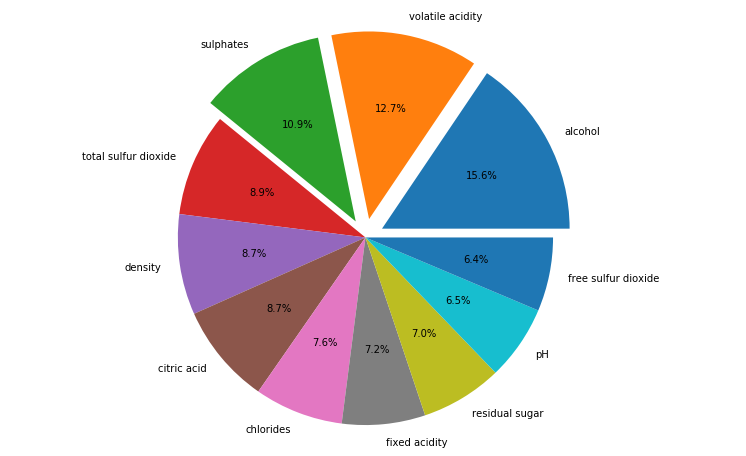

In [307]:
plt.figure(figsize=(13,8))
plt.pie(feature_scores, explode=[0.1, 0.1, 0.1, 0,0,0,0,0,0,0,0], labels=feature_scores.index, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Our top 3 features (alcohol, volatile acidity, and sulphates) account for 39% of the variance in the data.  Lets try to model with these features.

In [369]:
goodwine = wine[wine['quality_bins']=='Good'].sample(n=(int(1319*.6)), random_state=9192)
greatwine = wine[wine['quality_bins']=='Great'].sample(n=(int(217*.9)), random_state=9193)
poorwine = wine[wine['quality_bins']=='Poor']
new2_wine = pd.concat([goodwine, greatwine, poorwine])

from sklearn.ensemble import RandomForestClassifier
rfc3 = RandomForestClassifier(criterion='gini', n_estimators=400)

Ytrain3 = new2_wine['quality_bins']
Xtrain3 = new2_wine[['alcohol', 'volatile acidity', 'sulphates']]

rfc3.fit(Xtrain3, Ytrain3)

print('Model score (test dataset):',rfc3.score(Xtrain3, Ytrain3), '\n')

print('Five fold cross validation scores (test dataset):', cross_val_score(rfc3, Xtrain3, Ytrain3, cv=5, scoring='accuracy'), '\n')

Xtest1 = Xtest[['alcohol', 'volatile acidity', 'sulphates']]

predicted3 = rfc3.predict(Xtest1)

print('Model score (entire dataset):\n', rfc3.score(Xtest1, Ytest), '\n')

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(predicted3, Ytest)
print('Confusion Matrix (entire dataset): \n',confusion_matrix(predicted3, Ytest))

Model score (test dataset): 0.998093422306959 

Five fold cross validation scores (test dataset): [0.77725118 0.81428571 0.8047619  0.79425837 0.83253589] 

Model score (entire dataset):
 0.9712320200125079 

Confusion Matrix (entire dataset): 
 [[1285   12    0]
 [  33  205    0]
 [   1    0   63]]


In [370]:
zz = rfc_.predict(Xtest)

print(rfc_.score(Xtest, Ytest))

print(confusion_matrix(zz, Ytest))

0.9881175734834271
[[1318   10    8]
 [   1  207    0]
 [   0    0   55]]


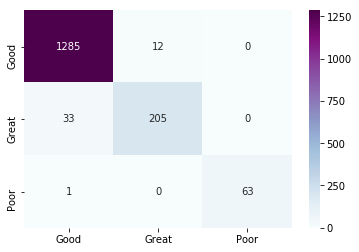

In [371]:
ax = sns.heatmap(confusion, cmap='BuPu', annot=True, fmt="d",xticklabels=['Good', 'Great', 'Poor'],
           yticklabels=['Good', 'Great', 'Poor'] )

In [372]:
confusion/list(wine.quality_bins.value_counts())

array([[9.74222896e-01, 5.52995392e-02, 0.00000000e+00],
       [2.50189538e-02, 9.44700461e-01, 0.00000000e+00],
       [7.58150114e-04, 0.00000000e+00, 1.00000000e+00]])

In [373]:
wine.quality_bins.value_counts()

Good     1319
Great     217
Poor       63
Name: quality_bins, dtype: int64

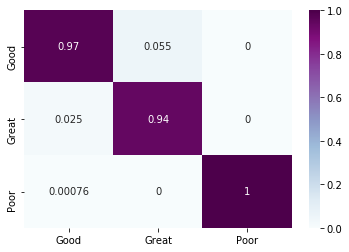

In [374]:
sns.heatmap(confusion/list(wine.quality_bins.value_counts()), cmap='BuPu', annot=True, xticklabels=['Good', 'Great', 'Poor'],
           yticklabels=['Good', 'Great', 'Poor'])

Plotting the three most important features gets a model score better than the Random Forest Classifier with all 11 features.  Trimming down the features allowed me to increase the n_estimators as well without sacrificing model performance.  Despite alcohol, volatile acidity, and sulphates explaining 39% of the variance, these features allow me to create an accurate model.  

Reducing our model to using 3 features would make it easier to apply this in the real world as well.  Less features mean less data collection.  




## Considerations for model improvement:
* I could change the classes scheme from three classes to a binary classification.
* Could classify with the initial 8 wine qualities
* More data especially balanced data
* Increased feature engineering for better more explanatory features
* Other features such as wine price, wine brand, grape types

## Limitations:
* If I were to change the outcome variable to quality (On scale of 1-10) the model 
    would not be able to predict 1-3 or 9-10 because it hasn't seen those outcomes
* Getting the physiochemical properties of wine may not be practical or cost-efficient
* This model is only trained on the Portuguese 'Vinho Verde' wine, therefore this model may not apply to other types of wine.
    * Need to incorporate other wine types into training and/or test the model on other wine types.
* Do not how quality is surmised, may be from sommeliers but not sure.  Could be slightly subjective.  

# Acknowledgements:

Context:
- The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

Acknowledgements:
- This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (I am mistaken and the public license type disallowed me from doing so, I will take this down at first request. I am not the owner of this dataset.

Relevant publication:
- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.